In [137]:
import numpy as np
from scipy import optimize as op
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from fp_plotting_funcs import *
from statistics import median

/Users/pnr5sh/miniconda3/envs/astro/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Uncleaned Lightcurves - 20ano')

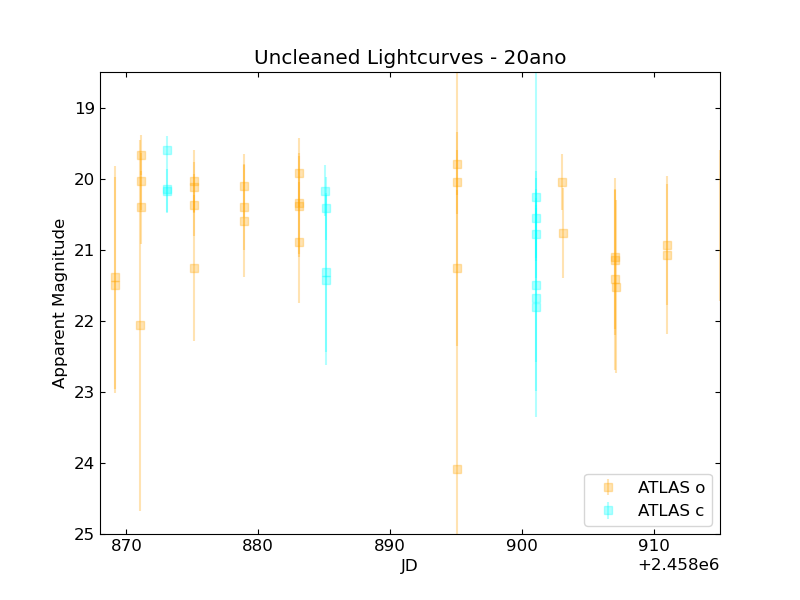

In [138]:
sn20ano_ztf = read_in_data('../../data/forced_phot_data/20ano_fp_lc.txt', data_source='ztf_fp')

sn20ano_at = read_in_data('../../data/forced_phot_data/sn20ano_atlas.txt', data_source='atlas')

multi_band_plot(sn20ano_ztf, _, sn20ano_at, ID='20ano', xlims=[868+2.458e6, 915+2.458e6], ylims=[25,18.5],save=False, ztf=False, atlas=True, asassn=False)
plt.title('Uncleaned Lightcurves - 20ano')

In [139]:
#cleaning data

In [140]:
def get_mag_from_atlas_fp(filename):
    """
    Processes the results of an ATLAS FP request into final magnitudes.
    Takes as input the name of a file containing raw ATLAS FP data
    and returns a dictionary of cleaned, final magnitudes
    """

    cols_atlas = ['MJD', 'm', 'dm', 'uJy', 'duJy', 'F', 'err', 'chi/N', 'RA', 'Dec', 'x', 'y', 'maj', 'min', 'phi', 'apfit', 'mag5sig', 'Sky', 'Obs']
    full_df = pd.read_csv(filename, skiprows=1, names=cols_atlas, delim_whitespace=True)
    
    colors = {'c': 'cyan', 'o': 'orange'}
    atlas_data = {}
    for filt in ['c', 'o']:

        df = full_df[(full_df['F'] == filt) & (full_df['chi/N'] < 4.0)].reset_index(drop=True)

        if len(df) == 0:
            continue

        mjdmin = int(df['MJD'].iloc[0]) - 1
        mjdmax = int(df['MJD'].iloc[-1]) - 1
        mjds = np.linspace(mjdmin, mjdmax, int(mjdmax-mjdmin)+1)

        ### Bin dataframe by mjds
        df['bin'] = pd.cut(df['MJD'], mjds, labels=mjds[:-1])
        
        snt = 3
        snu = 5

        for mjd in mjds:
            # Get rows that fell into this bin
            good = np.where((df['bin'] == mjd))[0]
            if len(good) == 0:
                continue

            avg_mjd = np.average(df['MJD'][good])
            avg_fluxes = np.average(df['uJy'][good], weights=1/df['duJy'][good].values**2)
            avg_flux_errs = 1 / np.sqrt(sum([1/err**2 for err in df['duJy'][good].values]))

            if avg_fluxes / avg_flux_errs > snt:
                avg_mag = -2.5*np.log10(avg_fluxes) + 23.9
                avg_mag_err = 1.0857 * avg_flux_errs / avg_fluxes

                plt.errorbar(avg_mjd, avg_mag, yerr=avg_mag_err, fmt='o', color=colors[filt], mec='black')

            else:
                avg_mag = -2.5*np.log10(snu * avg_flux_errs) + 23.9
                avg_mag_err = 9999

                plt.scatter(avg_mjd, avg_mag, marker='v', color=colors[filt], edgecolor='black', alpha=0.5)

            atlas_data.setdefault(filt, []).append({'mag': avg_mag, 'err': avg_mag_err, 'mjd': avg_mjd})

    plt.gca().invert_yaxis()
    plt.show()

    return atlas_data   

In [141]:
def process_ztf_fp(filename, jdstart, jdend):

    """
    Processes the raw ZTF forced photometry from saved file
    and returns a Pandas dataframe of the cleaned data
    """

    full_df = pd.read_csv(filename, delim_whitespace=True, comment='#', header=0, names=['sindex', 'field', 'ccdid', 'qid', 'filter',
                            'pid', 'infobitssci', 'sciinpseeing',
                            'scibckgnd', 'scisigpix', 'zpmaginpsci',
                            'zpmaginpsciunc', 'zpmaginpscirms',
                            'clrcoeff', 'clrcoeffunc', 'ncalmatches',
                            'exptime', 'adpctdif1', 'adpctdif2',
                            'diffmaglim', 'zpdiff', 'programid', 'jd',
                            'rfid', 'forcediffimflux',
                            'forcediffimfluxunc', 'forcediffimsnr',
                            'forcediffimchisq', 'forcediffimfluxap',
                            'forcediffimfluxuncap', 'forcediffimsnrap',
                            'aperturecorr', 'dnearestrefsrc',
                            'nearestrefmag', 'nearestrefmagunc',
                            'nearestrefchi', 'nearestrefsharp',
                            'refjdstart', 'refjdend', 'procstatus'])

    # Get rid of bad data
    df = full_df[(full_df['infobitssci'] < 33554432) & (full_df['scisigpix'] <= 25) & (full_df['sciinpseeing'] <= 4)].reset_index(drop=True)

    # Make baseline correction
    colors = {'ZTF_g': 'green', 'ZTF_r': 'red', 'ZTF_i': 'brown'}
    # plt.figure()

    for filt in ['ZTF_g', 'ZTF_r', 'ZTF_i']:
        ### Get unique values of field, ccdid, qid
        fields = set(df[df['filter'] == filt]['field'].values)
        ccdids = set(df[df['filter'] == filt]['ccdid'].values)
        qids = set(df[df['filter'] == filt]['qid'].values)        
       
        for field in fields:
            for ccdid in ccdids:
                for qid in qids:
                    current_df = df[(df['filter'] == filt) & (df['field'] == field) & (df['ccdid'] == ccdid) & 
                                    (df['qid'] == qid) & ((df['jd'] < jdstart - 20) | (df['jd'] > jdend + 20))]
                    if len(current_df.index) < 30:
                        print('Not enough epochs to estimate baseline for ', filt)
                        continue

                    # plt.errorbar(current_df['jd'], current_df['forcediffimflux'], yerr=abs(current_df['forcediffimfluxunc']),
                    #              fmt='o', color=colors[filt], mec='k', label=filt)
                    median_flux = median(current_df['forcediffimflux'])
                    print(filt, median_flux)
                    df.loc[(df['filter'] == filt) & (df['field'] == field) & (df['ccdid'] == ccdid) & (df['qid'] == qid), 'forcediffimflux'] -= median_flux        
    # plt.legend()
    # plt.xlim(jdstart-100, jdend+100)
    # plt.title('corrected/cleaned flux')
    # plt.show()

    return df


def get_mag_from_ztf_fp(full_df):

    """
    Takes as input a dataframe of cleaned ZTF forced photometry
    and returns a dictionary fo the stacked, magnitude-calibrated
    final photometry
    """
    
    colors = {'ZTF_g': 'green', 'ZTF_r': 'red', 'ZTF_i': 'brown'}
    ztf_data = {}

    ### Bin dataframe by jd
    jdmin = int(full_df['jd'].iloc[0]) - 1
    jdmax = int(full_df['jd'].iloc[-1]) - 1
    jds = np.linspace(jdmin, jdmax, int(jdmax-jdmin)+1)
    full_df['bin'] = pd.cut(full_df['jd'], jds, labels=jds[:-1])

    plt.figure() 
    
    for filt in ['ZTF_g', 'ZTF_r', 'ZTF_i']:
        df = full_df[full_df['filter'] == filt]
        mags, mag_errs, uplims = [],[],[]
        
        for d in jds:
            # Get rows that fell into this bin
            inbin = np.where((df['bin'] == d))[0]
            if len(inbin) == 0:
                continue

            avg_jd = np.average(df.jd.values[inbin])
            avg_fluxes = np.average(df.forcediffimflux.values[inbin], weights=1/df.forcediffimfluxunc.values[inbin]**2)
            avg_flux_errs = 1 / np.sqrt(sum([1/err**2 for err in df.forcediffimfluxunc.values[inbin]]))
            avg_zpdiff = np.average(df.zpdiff.values[inbin])

            # # df['nearestrefflux'] = 10**(0.4 * (df['zpdiff'] - df['nearestrefmag']))
            # # df['nearestreffluxunc'] = df['nearestrefmagunc'] * df['nearestrefflux'] / 1.0857

            snt = 3
            snu = 5

            df.drop_duplicates(['pid', 'forcediffimflux', 'forcediffimfluxunc'],
                                inplace=True)
            df=df.reset_index(drop=True)
            m, dm, uplim = float(), float(), float()
            if avg_fluxes / avg_flux_errs > snt: # good measurement
                m = avg_zpdiff - 2.5*np.log10(avg_fluxes)
                dm = 1.0857 * avg_flux_errs / avg_fluxes
                mags.append(m)
                mag_errs.append(dm)
                plt.errorbar(avg_jd, m, yerr=dm, fmt='o', color=colors[filt], mec='black', label=filt)
            else:
                uplim = avg_zpdiff - 2.5*np.log10(snu * avg_flux_errs)
                dm = 9999
                uplims.append(uplim)
                mag_errs.append(dm)
                plt.scatter(avg_jd, uplim, marker='v', color=colors[filt], edgecolor='black')
            
            ztf_data.setdefault(filt, []).append({'mag': m, 'err': dm, 'mjd': avg_jd-2400000.5})
        
    plt.gca().invert_yaxis()
    # plt.legend()
    plt.title('cleaned+binned in magnitude')
    plt.show()
    
    return ztf_data

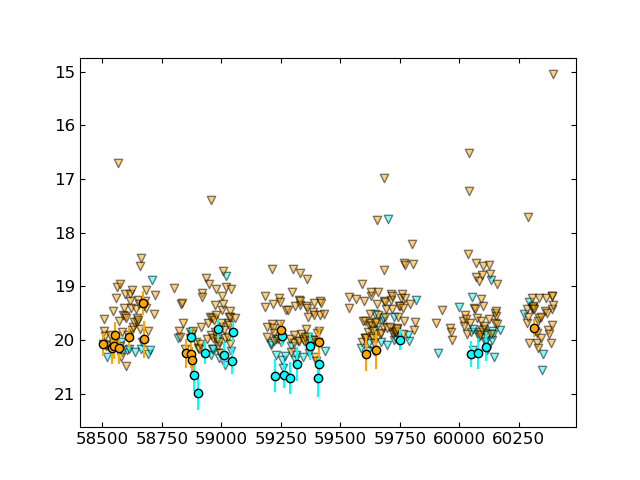

(58867.5, 58914.5)

In [142]:
%matplotlib ipympl
plt.figure()
sn20ano_at_clean = get_mag_from_atlas_fp('../../data/forced_phot_data/sn20ano_atlas.txt')
plt.xlim(868+2.458e6-2400000.5, 915+2.458e6-2400000.5)

Not enough epochs to estimate baseline for  ZTF_g
Not enough epochs to estimate baseline for  ZTF_g
Not enough epochs to estimate baseline for  ZTF_g
ZTF_g -1.523463328789095
ZTF_g 0.540736734236196
Not enough epochs to estimate baseline for  ZTF_g
Not enough epochs to estimate baseline for  ZTF_g
Not enough epochs to estimate baseline for  ZTF_g
Not enough epochs to estimate baseline for  ZTF_r
Not enough epochs to estimate baseline for  ZTF_r
Not enough epochs to estimate baseline for  ZTF_r
ZTF_r -1.307809389331975
ZTF_r -2.65538872428321
Not enough epochs to estimate baseline for  ZTF_r
Not enough epochs to estimate baseline for  ZTF_r
Not enough epochs to estimate baseline for  ZTF_r
Not enough epochs to estimate baseline for  ZTF_i
Not enough epochs to estimate baseline for  ZTF_i
Not enough epochs to estimate baseline for  ZTF_i
ZTF_i -3.13967152112645
ZTF_i 4.99839912758275
Not enough epochs to estimate baseline for  ZTF_i
Not enough epochs to estimate baseline for  ZTF_i
Not e

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_49137/1177444721.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(['pid', 'forcediffimflux', 'forcediffimfluxunc'],


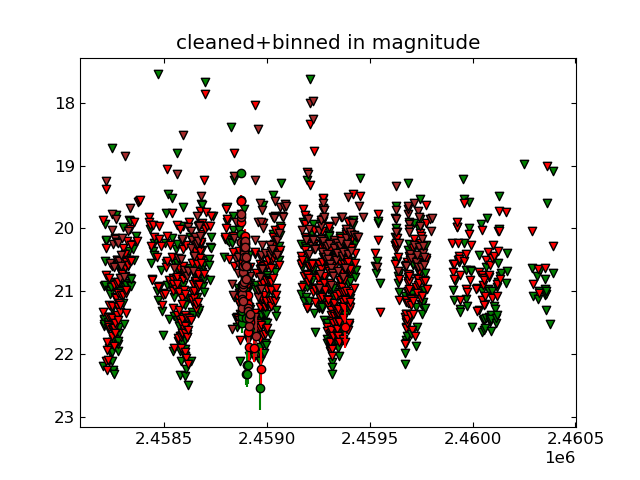

(2458866.0, 2458900.0)

In [143]:
%matplotlib ipympl
ztf_df = process_ztf_fp('../../data/forced_phot_data/20ano_fp_lc.txt', 840+2.458e6 , 915+2.458e6)
sn20ano_ztf_clean = get_mag_from_ztf_fp(ztf_df)
plt.xlim(866+2.458e6, 900+2.458e6)

In [148]:
#converting atlas data dict into dataframe 
# to export to mcmc fitting

#atlas
sn20ano_clean_df = pd.DataFrame(columns=['mag','err','mjd','filter'])

for i in range(len(sn20ano_at_clean['c'])):
    data = list(sn20ano_at_clean['c'][i].values())
    data.append('c')
    sn20ano_clean_df.loc[len(sn20ano_clean_df.index)] = data

for i in range(len(sn20ano_at_clean['o'])):
    data = list(sn20ano_at_clean['o'][i].values())
    data.append('o')
    sn20ano_clean_df.loc[len(sn20ano_clean_df.index)] = data

#doing the same for ztf
sn20ano_ztf_clean_df = pd.DataFrame(columns=['mag','err','mjd','filter'])
for filt in sn20ano_ztf_clean.keys():
    for i in range(len(sn20ano_ztf_clean[filt])):
        data = list(sn20ano_ztf_clean[filt][i].values())
        data.append(filt)
        sn20ano_clean_df.loc[len(sn20ano_clean_df.index)] = data

#ignoring i-band for now
iband = (sn20ano_clean_df['filter']=='ZTF_i')
zeromag = (sn20ano_clean_df['mag']==0)
snthere = ((58870.5<=sn20ano_clean_df['mjd'])&(sn20ano_clean_df['mjd']<=58899.5))

sn20ano_clean_df_export = sn20ano_clean_df[(~iband)&(~zeromag)&(snthere)].reset_index(drop=True)
sn20ano_clean_df_export

,mag,err,mjd,filter
0,19.945834,0.174656,58872.593632,c
1,20.646913,0.311108,58884.599257,c
2,20.268021,0.262731,58870.575995,o
3,20.379721,0.256380,58874.637314,o
4,19.892769,9999.000000,58878.410303,o
5,19.824609,9999.000000,58882.604663,o
6,20.036815,9999.000000,58894.564031,o
7,19.121572,0.021868,58871.451854,ZTF_g
8,19.567475,0.033967,58872.438090,ZTF_g
9,20.095883,0.047709,58873.390654,ZTF_g


In [149]:
sn20ano_clean_df_export.to_csv('./sn20ano_cleaned_binned_cut.csv',index=False)

In [114]:
################################################
#    loading in cleaned and averaged data
################################################

In [54]:
sn20ano_at_cl_c = pd.read_csv('../unclean_data/2020ano/2020ano.c.1.00days.lc.txt',delim_whitespace=True)
sn20ano_at_cl_o = pd.read_csv('../unclean_data/2020ano/2020ano.o.1.00days.lc.txt',delim_whitespace=True)
sn20ano_at_cl_c.columns

Index(['MJD', 'MJDbin', 'uJy', 'duJy', 'stdev', 'x2', 'Nclip', 'Ngood',
       'Nexcluded', 'Mask', 'm', 'dm'],
      dtype='object')

In [47]:
sn20ano_at_cl_c = sn20ano_at_cl_c.dropna(axis=0, ignore_index=True, subset='MJD')
print(len(sn20ano_at_cl_c.MJD))
sn20ano_at_cl_o = sn20ano_at_cl_o.dropna(axis=0, ignore_index=True, subset='MJD')
print(len(sn20ano_at_cl_o.MJD))

133
526


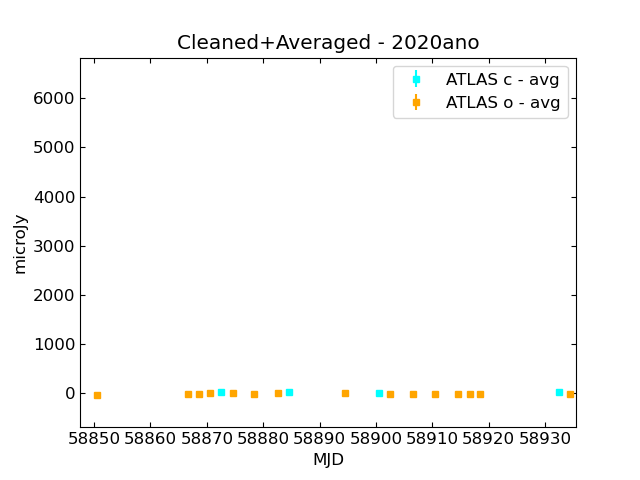

In [53]:
plt.figure()
#atlas
plt.errorbar(sn20ano_at_cl_c.MJD, sn20ano_at_cl_c.uJy, yerr=sn20ano_at_cl_c.duJy, 
             linestyle='', marker='s', color='cyan', markersize=5, label='ATLAS c - avg')
plt.errorbar(sn20ano_at_cl_o.MJD, sn20ano_at_cl_o.uJy, yerr=sn20ano_at_cl_o.duJy, 
             linestyle='', marker='s', color='orange', markersize=5, label='ATLAS o - avg')
#ZTF
# ...

#fake atlas
# plt.errorbar(jd_o_avgs-2400000.5, flux_o_avgs, flux_o_errs, linestyle='', marker='*', color='red', markersize=10)


plt.xlim(58847.5,58935.5)
# plt.ylim(19,20)
# plt.ylim(-30, 60)
plt.legend()
plt.title('Cleaned+Averaged - 2020ano')
plt.xlabel('MJD')
plt.ylabel('microJy')
plt.show()

In [49]:
# ztf
print('pre-cut length:', len(sn20ano_ztf['forcediffimflux']))
bad_cuts = (sn20ano_ztf['infobitssci']>33554432) | (sn20ano_ztf['scisigpix'] > 25) | (sn20ano_ztf['sciinpseeing']>4)
# good_cuts = ~bad_cuts
sn20ano_ztf_good = sn20ano_ztf[~bad_cuts]
print('post-cut length:', len(sn20ano_ztf_good['forcediffimflux']))
print('removed:', len(sn20ano_ztf['forcediffimflux'])-len(sn20ano_ztf_good['forcediffimflux']))

pre-cut length: 3919
post-cut length: 3682
removed: 237


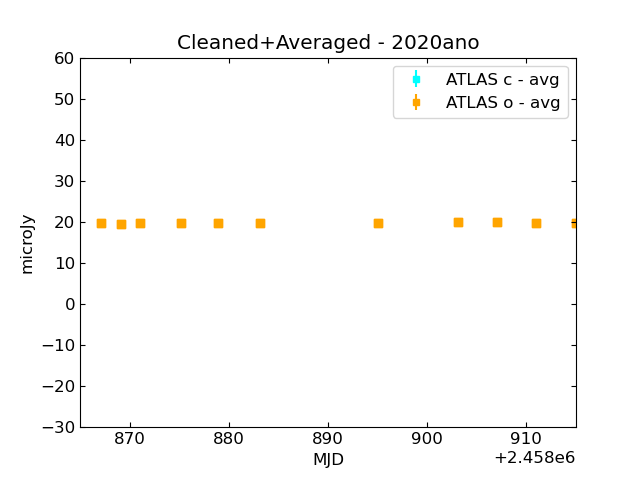

In [51]:
# # plot mags
# plt.figure()
# err_g = shape_err(sn20ano_ztf_good, filter='ZTF_g')
# err_r = shape_err(sn20ano_ztf_good, filter='ZTF_r')
# err_i = shape_err(sn20ano_ztf_good, filter='ZTF_i')

# plt.errorbar(sn20ano_ztf_good[sn20ano_ztf_good['filter']=='ZTF_g']['jd'], sn20ano_ztf_good[sn20ano_ztf_good['filter']=='ZTF_g']['mag'], err_g,
#                 color='green', alpha=0.3, label='ZTF_g', linestyle='', marker='o')
# plt.errorbar(sn20ano_ztf_good[sn20ano_ztf_good['filter']=='ZTF_r']['jd'], sn20ano_ztf_good[sn20ano_ztf_good['filter']=='ZTF_r']['mag'], err_r,
#             color='red', alpha=0.3, label='ZTF_r', linestyle='', marker='o')
# plt.errorbar(sn20ano_ztf_good[sn20ano_ztf_good['filter']=='ZTF_i']['jd'], sn20ano_ztf_good[sn20ano_ztf_good['filter']=='ZTF_i']['mag'], err_i,
#             color='goldenrod', alpha=0.3, label='ZTF_i', linestyle='', marker='o')

plt.scatter(sn20ano_at_cl_o.MJD+2400000.5, sn20ano_at_cl_o.m, marker='s', color='orange')


plt.xlim(865+2.458e6, 915+2.458e6)
plt.show()
# plt.ylim(25,18.5)
# plt.ylabel('mag')

# #plot flux
# # %matplotlib qt
# # plt.figure()
# # plt.errorbar(sn20ano_ztf_good[sn20ano_ztf_good['filter']=='ZTF_g']['jd'],
# #              sn20ano_ztf_good[sn20ano_ztf_good['filter']=='ZTF_g']['forcediffimflux'],
# #              sn20ano_ztf_good[sn20ano_ztf_good['filter']=='ZTF_g']['forcediffimfluxunc'],
# #                 color='green', alpha=0.3, label='ZTF_g', linestyle='', marker='o')
# # plt.errorbar(sn20ano_ztf_good[sn20ano_ztf_good['filter']=='ZTF_r']['jd'],
# #              sn20ano_ztf_good[sn20ano_ztf_good['filter']=='ZTF_r']['forcediffimflux'],
# #              sn20ano_ztf_good[sn20ano_ztf_good['filter']=='ZTF_r']['forcediffimfluxunc'],
# #              color='red', alpha=0.3, label='ZTF_r', linestyle='', marker='o')
# # plt.errorbar(sn20ano_ztf_good[sn20ano_ztf_good['filter']=='ZTF_i']['jd'],
# #              sn20ano_ztf_good[sn20ano_ztf_good['filter']=='ZTF_i']['forcediffimflux'],
# #              sn20ano_ztf_good[sn20ano_ztf_good['filter']=='ZTF_i']['forcediffimfluxunc'],
# #              color='goldenrod', alpha=0.3, label='ZTF_i', linestyle='', marker='o')
# # # plt.axhline(y=0, zorder=0, color='k')
# # # plt.axhline(y=75, zorder=0, color='k')
# # plt.xlim(855+2.458e6, 920+2.458e6)
# # plt.ylabel('flux')